# **Basics of Mobile robotics**
### **Project**

**Paul Huot-Marchand** 
**Luca**
**Manuela** 
 

**Date:** *2025*

# **INTRODUCTION**
Our project take place on a rectangular white environment with black obstacles of any shapes a black circle as goal and a  black isocele triangle on the robot. The goal was to implement global navigation using the camera provided creating a global occupancy map, then applying an A* algorithm to find an optimized path. A filter was implemented to track position of the robot. Local avoidance was implemented to avoid la minuit added obstacles using thymio infrared sensors.

## **I Computer Vision**
The steps of our computer vision part is as follow : 
- Detect the environment,
- Correct percpective,
- detect obstacles and goal to fill occupancy map
- detect the robot

To do so a general filtering framework was adopted. First convert to gray scale, apply bilateral filter to enhance edge and remove noise, apply canny filter to detect edges, apply morphological filter to close as much as possib

In [1]:
!pip install tdmclient numpy scipy opencv-python tqdm


In [1]:
import numpy as np
from scipy.ndimage import distance_transform_edt
import cv2
import tqdm
from Computer_vision import cv as com
#import Filtering as flt 
from Global_Nav import global_nav as gb
import matplotlib.pyplot as plt

import math as m
import numpy as np
from collections import deque
from matplotlib.animation import FuncAnimation

from Filtering import Control_fromEKF as control
from Filtering import Filtering as filt
from Local_Nav import local_nav as ln



In [2]:
# Initiate the communication between the Thymio and the computer
from tdmclient import ClientAsync, aw
client = ClientAsync()

node = await client.wait_for_node()
await node.lock() 

Node 7e5a04de-7cbe-4397-8545-f33016b69c2f

In [3]:
def length_real_to_pixel(length_cm, env_size_cm, map_size):
    
    L, W = env_size_cm
    height, width = map_size
    
    # scale factors
    scale_x = width / L
    scale_y = height / W
    
    # average scale for uniform scaling
    scale = (scale_x + scale_y) / 2
    
    return length_cm * scale
    
#================HYPERPARAMETESRS======================

#SiZE OF THE ENVIRONEMENT (cm)
L = 113.5
W = 81.3
Ratio = L/W

#SiZE IN PIXEL OF THE CORRECTED MAP
Y_res = 480
SIZE = [Y_res, int(Y_res*Ratio)]

#SIZE OF THE TRIANGLE (cm)
L_T = 10
H_T = 3.5
L_T_p = length_real_to_pixel(L_T,[L,W], SIZE)
H_T_p = length_real_to_pixel(H_T,[L,W], SIZE)

#SIZE OF THE GOAL (cm)
R_G = 8.4/2

R_G_p = length_real_to_pixel(R_G,[L,W], SIZE)

# AREA RATIO
RATIO_T = (L_T*H_T/2) / (L*W) 

#FILTERING PARAMETERS FOR THE ORIGINAL IMAGE
B1_O = 10
B2_O = 80
B3_O = 80
C1_O = 0.5
C2_O = 1.5
M1_O = 8
CL1_O = 2.0
M_O = 5
D_O = 5

#FILTERING PARAMETERS FOR THE CORRECTED IMAGE
B1_C = 5
B2_C = 8
B3_C = 8
C1_C = 0.4
C2_C = 1.6
M1_C = 5
CL1_C = 4.0
M_C = 5
D_C = 5

#FILTERING PARAMETERS FOR ROBOT DETECTION
B1_T = 5
B2_T = 10
B3_T = 10
C1_T = 0.4
C2_T = 1.6
M1_T = 5
CL1_T = 2
M_T = 2
D_T = 2


#PARAMETERS TO DETECT THE ENV
Min_area_env = 1920*1080*0.4   #Min area in pixel of the env
Env_approx = 0.01

#PARAMETERS TO DETECT THE OBSTACLES
Min_area_obs = SIZE[0]*SIZE[1]*0.005   #Min area in pixel of the env
Max_area_obs = SIZE[0]*SIZE[1]*0.5   #Max area in pixel of the env
Obs_approx = 0.01

#PARAMETERS TO DETECT GOAL
Min_area_goal = np.pi * R_G_p * R_G_p *0.8
Max_area_goal = np.pi * R_G_p * R_G_p * 1.8

#PARAMETERS TO DETECT THE ROBOT
Min_area_rob = (L_T_p*H_T_p /2) * 0.8   #Min area in pixel of the env
Max_area_rob =  (L_T_p*H_T_p /2) * 1.2
Rob_approx = 0.08

#ROBOT CARACTERISTICS
R_ROBOT = 6
R_ROBOT_p = length_real_to_pixel(R_ROBOT,[L,W], SIZE)


#SYMBOLS FOR THE MAP
FREE_SPACE = 0
OCCUPIED_SPACE = -1
GOAL = -3

DEBUG = False

# IR SENSORS CALIBRATION
#========================================================

In [4]:
if DEBUG : 
    import matplotlib.pyplot as plt
    %matplotlib inline
#GLOBAL FRAMEWORK TO USE VISION
#EXECUTE CELL ABOVE WITH DEBUG = TRUE FOR TUNING UNTIL EVERYTHING IS CORRECTLY FILTERED AND FOUND
cap = cv2.VideoCapture(1)
    
if not cap.isOpened():
    print("Could not access webcam")






ROBOT FOUND
MAP ANALYZED : 
GOAL FOUND
ROBOT FOUND


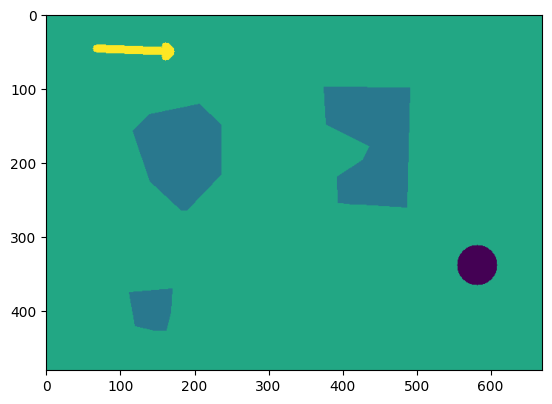

In [5]:
#INITIALIZATION
#GET A FRAME
img = com.get_picture_optimized(cap)
#img = cv2.imread("02.png")
#COMPUTE TRANSFORMATION MATRIX
matrix = com.matrix_perspective(img)
#CORRECT IMAGE
transformed_image = com.convert_perspective(img,matrix)

#PLOTTING
if DEBUG: 
    plt.figure()
    plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    plt.title("Perspective Corrected Image")
    plt.axis('off')
    plt.show()


#GET GLOBAL MAP
global_map = com.get_map(transformed_image)

#GET ROBOT POSITION AND ORIENTATION
robot = com.get_robot(transformed_image)


length = 100
end_x = int(robot[0][0] + length * np.cos(robot[1]))
end_y = int(robot[0][1] + length * np.sin(robot[1]))
end_point = (end_x, end_y)
global_map4plot = global_map.copy()
cv2.arrowedLine(global_map4plot, [int(robot[0][0]), int(robot[0][1])], end_point, color=(2, 2, 2), thickness=10)
plt.imshow(global_map4plot)
plt.show()
if DEBUG : 
    global_map4plot = global_map.copy()
    cv2.arrowedLine(global_map4plot, robot[0], end_point, color=(2, 2, 2), thickness=10)
    plt.imshow(global_map4plot)
    plt.axis('off')
    plt.show()


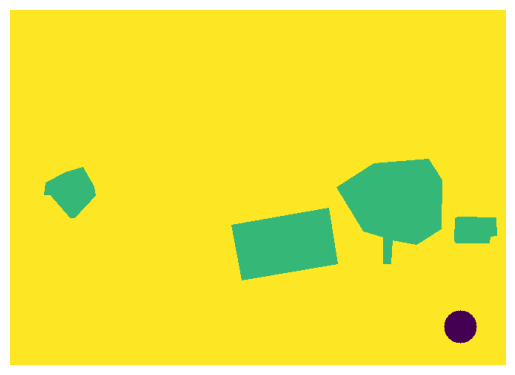

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[-3 -1  0]


In [23]:
#global_map[global_map == 1.] = -1.
global_map = global_map.astype(int)
from matplotlib import pyplot as plt
plt.imshow(global_map)
plt.axis('off')
plt.show()
print(global_map)
print(np.unique(global_map))

In [8]:
print(robot[0][1])

250.93449781659388


In [9]:
robot[0][0]

np.float64(240.00873362445415)

In [10]:
print(len(global_map[0]))

670


In [11]:
print(len(global_map))


480


In [12]:
int(round(robot[0][1]))

251

In [13]:
int(round(robot[0][0]))

240

In [7]:
solved = global_map[:]

path = path = gb.a_star(global_map, robot[1], 0.25, 
                 (int(round(robot[0][1])), int(round(robot[0][0]))))


480
670
46
69
120870


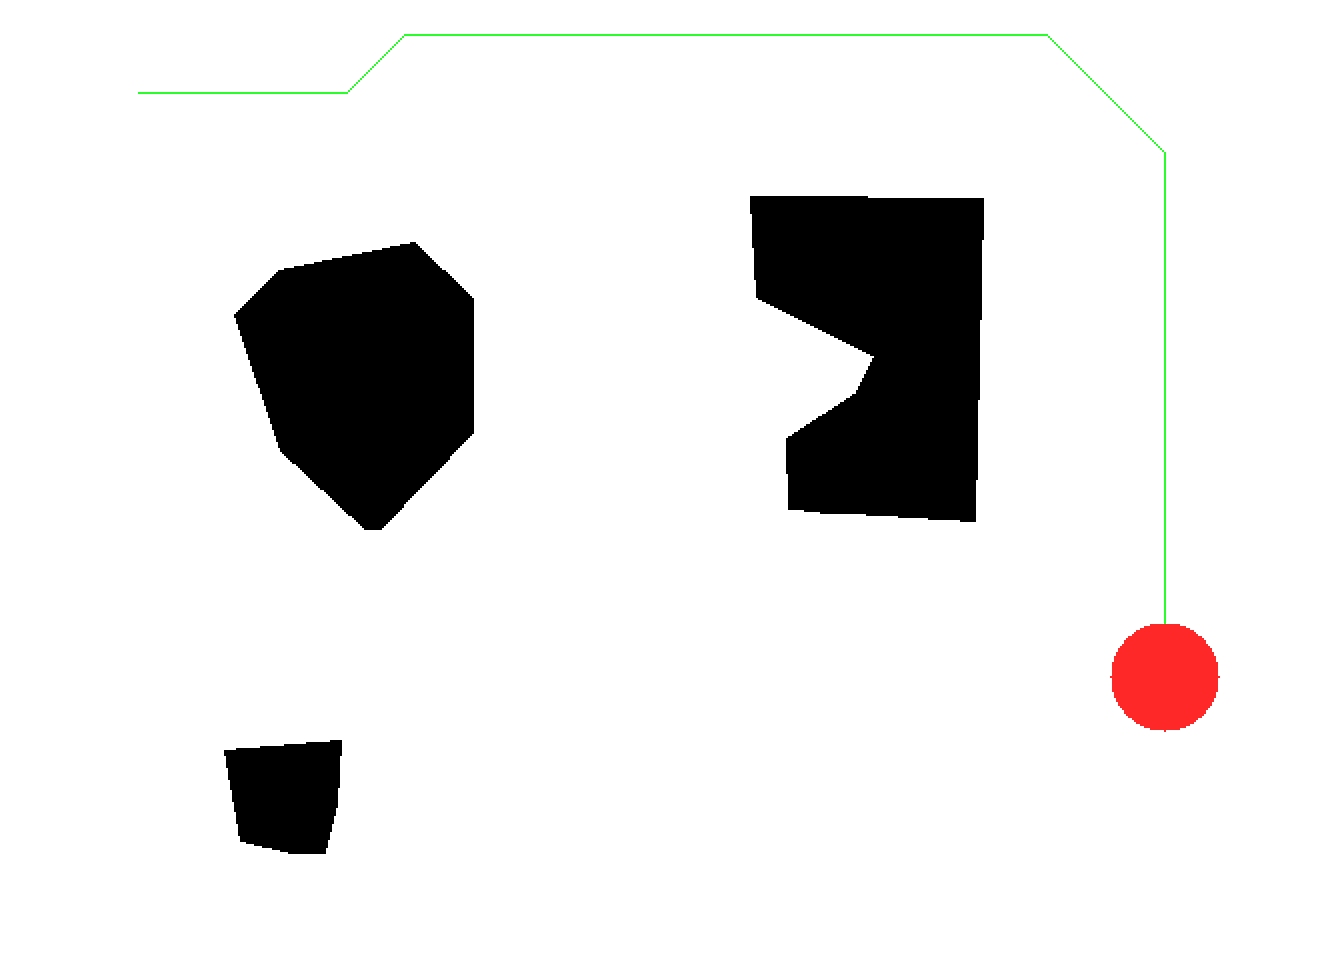

In [8]:
## HERE : make infinite loop that launches Filtering, motion and local avoidance
#empty = np.zeros((SIZE[0], SIZE[1]))
for i in path : 
     global_map[i[0]][i[1]] = -4 # marker for path in my debug functions

gb.debug_maze_to_bitmap(global_map, 2, filename="Global_Nav/tests/maze.png")

In [ ]:
# params ekf
Ts = 0.1  # time step in seconds
L = 95  # distance between wheels in mm
speed_to_mms = 0.3375  # conversion factor from thymio speed units to mm/s from solution ex.8 (in our measurement it was 0.43478260869565216)

# Process noise for EKF (tune) (from model-mismatch/random-walk/control execution)
q_proc = (
    1e-10, 1e-10, 1e-3,   # q_x, q_y, q_theta (model mismatch)
    75.72,  0.002692,         # q_v_ctrl, q_omega_ctrl (control execution noise)
    1e-2, 1e-5          # q_v_bias, q_omega_bias (random walk on v, omega)
)
# Camera measurement noise (tune)
r_cam = (1.435, 1.864, 0.001496)  # [mm^2, mm^2, rad^2]
r_mot = (75.72, 0.002692)    # motor noise on v, omega

def pixel_to_world_mm(pos):
    px, py = pos
    x = 10 * px * (L / SIZE[1])
    y = 10 * py * (W / SIZE[0])
    return x, y

conv_x = 10 * (L / SIZE[1])
conv_y = 10 * (W / SIZE[0])
# 1) buffers
traj = deque(maxlen=2000)   # (x,y)
# convert path!
waypoints = control.remove_collinear(control.grid_to_mm(path, cell_size_mm_x=conv_x, cell_size_mm_y=conv_y))
plot_wps = waypoints
way_mm = control.grid_to_mm(path, cell_size_mm_x=conv_x, cell_size_mm_y=conv_y)
# init EKF, get first img
img = com.get_picture_optimized(cap)
matrix = com.matrix_perspective(img)
image = com.convert_perspective(img,matrix)
pos, angle, __ = com.get_robot(image)
pos = pixel_to_world_mm(pos)
x = pos[0]
y = pos[1]
x0=[x, y, angle,0,0]
ekf = filt.EKFState(x0, P0=1000*np.eye(5))
#print(ekf)
ekf_traj = [] # for plot
# memory for plots
def ekf_get_state():
    s = ekf.get_state()  # (x,y,theta)
    ekf_traj.append((s[0], s[1], s[2]))  # log x,y each time it's called
    return s
image = []

# start connect to Thymio
#client = ClientAsync()
#node = aw(client.wait_for_node())
try:
    aw(node.lock()) # lock the node for R/W
except Exception:
    pass # ignore it it wasn't locked

aw(node.stop())
print("Connected:", node)
motors = aw(node.wait_for_variables({"motor.left.speed","motor.right.speed"}))

# helper functions:
def get_motor_meas(): 
    # raw speeds in Thymio units (instantaneous)
    vl = int(node.v.motor.left.speed)
    vr = int(node.v.motor.right.speed)
    print("get_motor_meas", vl, vr)
    # convert to v [mm/s], omega [rad/s] 
    v, w = filt.motors_to_vw(vl, vr, speed_to_mms, L) 
    return np.array([v, w], dtype=float)

def get_cam_meas(image=None):
    # get position from camera
    if image is not None:
        pos, angle, __ = com.get_robot(image)
        #x = SIZE[1] - pos[0] 
        if pos==[]:
            return None
        pos = pixel_to_world_mm(pos)
        x = pos[0]
        y = pos[1]
        print("camera values:", x, y, angle)
        return np.array([x, y, angle], dtype=float)
    return None


try:
    obstacle_not_passed = False
    while waypoints:
        #GET image
        img = com.get_picture_optimized(cap)
        image = com.convert_perspective(img,matrix)
        # get motion params
        vl_cmd, vr_cmd = control.get_cmd()
        z_mot=get_motor_meas()
        z_cam = get_cam_meas(image)
        # calc ekf step
        ekf.step(vl_cmd, vr_cmd, z_cam, r_cam=r_cam, z_mot=z_mot, r_mot=r_mot, Ts=Ts, q_proc=q_proc)
        #print("ekf results:", ekf.x, ekf.P)
        state = ekf_get_state()
        # motion control
        print("waypoints:", waypoints)
        if not(ln.prox_less_threshold(list(node["prox.horizontal"][:5]), 1500)) or obstacle_not_passed :
            objectif = (waypoints[0][0]/10, waypoints[0][1]/10) 
            curr_dir = (100*m.cos(state[2]), 100*m.sin(state[2]))
            curr_pos = (state[0]/10, state[1]/10)
            obstacle_not_passed = True
            await node.wait_for_variables({"prox.horizontal"})
            prox_read = list(node["prox.horizontal"])
            if (ln.prox_less_threshold(prox_read, 1000)) and obstacle_not_passed:
                print("PASSED")
                control.set_motors(node, 100, 100)
                await client.sleep(2)
                obstacle_not_passed = False
                continue
            vect = ln.vect_calculation(objectif, (curr_pos),curr_dir,  prox_read[:5], 100, debug=False)
            norm_vect = m.sqrt(vect[0]**2 + vect[1]**2)
            curr_dir_norm = m.sqrt(curr_dir[0]**2+curr_dir[1]**2)
            angle_command = m.atan2(vect[1], vect[0])
            delta_speed = np.sign(angle_command)*min(abs(angle_command/ln.WAIT_TIME*800/m.pi), 300)
            left_speed = int(100+(delta_speed/2))
            right_speed = int(100-(delta_speed/2))
            control.set_motors(node, left=left_speed, right=right_speed)
            #print(f"{second_counter} : curr_pos = ({curr_pos[0]:.2f}, {curr_pos[1]:.2f}), vect = {angle_command:.2f} and delta_speed = {delta_speed:.2f}, curr_dir = ({curr_dir[0]:.2f}, {curr_dir[1]:.2f})")
            await client.sleep(ln.WAIT_TIME)
            continue
            #print(curr_dir, delta_speed*WAIT_TIME*m.pi/100, m.cos(delta_speed*WAIT_TIME*m.pi/100)
        obstacle_not_passed = False
        waypoints = aw(control.follow_path(node, state, waypoints, v_cmd=180, kp_heading=50.0,
                      pos_tol=12.0))
        
    
    x, y, th = ekf_get_state()[:3]
    print(f"Final pose (EKF): x={x:.1f} mm, y={y:.1f} mm, th={m.degrees(th):.1f} deg")
finally:
    aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))
    aw(node.unlock())
    # plots
    # Build arrays
    if len(ekf_traj) > 1:
        xs, ys, th = zip(*ekf_traj)
    else:
        xs, ys, th = [], [], []

    dxs, dys = zip(*way_mm)

    plt.figure(figsize=(6,6))
    # desired path
    plt.plot(dxs, dys, 'k--', lw=2, label='Desired path (waypoints)')
    plt.scatter(dxs, dys, c='k', s=20)
    Larr = 1.0 #arrow length
    Ux = Larr * np.cos(th)  # x-component of heading
    Vy = Larr * np.sin(th)  # y-component of heading
    plt.quiver(xs, ys,
               Ux, Vy,
               color='g', angles='xy', scale_units='xy', scale=1, alpha=0.7, label='rotation from ekf')
    plt.quiver(xs, ys,
               Larr*np.sin(xs), Larr*np.cos(ys),
               color='g',  angles='xy', scale_units='xy', scale=1, alpha=0.7, label='rotation from x,y')

    # actual path from EKF
    plt.plot(xs, ys, 'r-', lw=2, label='EKF trajectory')
    if xs and ys:
        plt.scatter([xs[0]],[ys[0]], c='g', s=40, label='Start (EKF)')
        plt.scatter([xs[-1]],[ys[-1]], c='r', s=40, label='End (EKF)')

    # WAYPOINTS
    for k, (xk, yk) in enumerate(plot_wps): 
        plt.text(xk, yk, f'{k}', color='blue', fontsize=8, label='waypoints')
    
    plt.axis('equal')
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    plt.title('Desired vs EKF trajectory')
    plt.legend()
    plt.grid(True)
    plt.show()

ROBOT FOUND
Connected: Node 7e5a04de-7cbe-4397-8545-f33016b69c2f
